In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import config
from Transmitter import Tx
from Receiver import Rx
from Fiber import Fiber,Amplifier

def MSE(a,b):
    return torch.abs(a - b).pow(2).mean()

def Acc(a,b):
    return torch.sum(a==b).item()/len(a)

In [2]:
# seting the system
k = int((config.Nch - 1)/2)  # 中心频道的序号
dbp_channels = 1
tx = Tx()
rx = Rx()
fiber = Fiber(tx.lam_set,length=1e5,alphaB=0.2,n2=2.7e-20,disp=17,dz=100,Nch=config.Nch,noise=True)

comp_disp = Fiber(tx.lam_set[k:k+1],length=1e5,alphaB=-0.2,n2=0,disp=-17,dz=100,Nch=1)
comp_single = Fiber(tx.lam_set[k:k+1],length=1e5,alphaB=-0.2,n2=-2.7e-20,disp=-17,dz=100,Nch=1)
comp_full = Fiber(tx.lam_set,length=1e5,alphaB=-0.2,n2=-2.7e-20,disp=-17,dz=100,Nch=config.Nch)
comp_train = Fiber(tx.lam_set[k:k+1],length=1e5,alphaB=-0.2,n2=-2.7e-20,disp=-17,dz=1e4,Nch=1,is_trained=True)
comp_meta = Fiber(tx.lam_set[k:k+1],length=1e5,alphaB=-0.2,n2=-2.7e-20,disp=-17,dz=1e4,Nch=1,is_trained=True,meta=True)

In [5]:
########################### Training META #############################
print('Training Start!')
Epoch = 20
batch = 64
use_gpu = torch.cuda.is_available()
optimizer = optim.Adam(params=comp_meta.parameters(),lr=0.001)
for epoch in range(Epoch):
    optimizer.zero_grad()
    x,_,_ = tx.data(batch=batch)   # sample a batch   x: batch x Nch x Nfft
    if use_gpu:
        x = x.cuda()
        comp_meta = comp_meta.cuda()
        fiber = fiber.cuda()
    y = fiber(x)        # y: batch x Nch x Nfft
    z = comp_meta(y[:,k:k+1,:])
    loss = MSE(z, x[:,k:k+1,:])
    loss.backward()
    print('epoch %d: loss: %g' % (epoch,loss.item()))
    optimizer.step()
print('Training done!')


Training Start!
epoch 0: loss: 3.96439
epoch 1: loss: 3.85678
epoch 2: loss: 3.76667
epoch 3: loss: 3.80895
epoch 4: loss: 3.92937
epoch 5: loss: 3.92674
epoch 6: loss: 3.83331
epoch 7: loss: 3.73073
epoch 8: loss: 3.85887
epoch 9: loss: 3.79237
epoch 10: loss: 3.74991
epoch 11: loss: 3.86827
epoch 12: loss: 4.15803
epoch 13: loss: 3.82697
epoch 14: loss: 3.99368
epoch 15: loss: 3.96045
epoch 16: loss: 3.83329
epoch 17: loss: 3.90307
epoch 18: loss: 3.80585
epoch 19: loss: 3.97805
Training done!


In [58]:
torch.save({'epoch':20,'loss':10.1,'model':comp_meta}, 'ckpt/meta.pt')

In [59]:
model = torch.load('ckpt/meta.pt')['model']

In [60]:
model

Fiber(
  (H_trained): ModuleList(
    (0): Meta_block(
      (fc0): complex_linear()
      (fc1): complex_linear()
    )
    (1): Meta_block(
      (fc0): complex_linear()
      (fc1): complex_linear()
    )
    (2): Meta_block(
      (fc0): complex_linear()
      (fc1): complex_linear()
    )
    (3): Meta_block(
      (fc0): complex_linear()
      (fc1): complex_linear()
    )
    (4): Meta_block(
      (fc0): complex_linear()
      (fc1): complex_linear()
    )
    (5): Meta_block(
      (fc0): complex_linear()
      (fc1): complex_linear()
    )
    (6): Meta_block(
      (fc0): complex_linear()
      (fc1): complex_linear()
    )
    (7): Meta_block(
      (fc0): complex_linear()
      (fc1): complex_linear()
    )
    (8): Meta_block(
      (fc0): complex_linear()
      (fc1): complex_linear()
    )
    (9): Meta_block(
      (fc0): complex_linear()
      (fc1): complex_linear()
    )
  )
  (scales): ModuleList(
    (0): Meta_block(
      (fc0): complex_linear()
      (fc1): comp

In [6]:
########################### Training DBP #############################
print('Training Start!')
Epoch = 20
batch = 64
use_gpu = torch.cuda.is_available()
optimizer = optim.Adam(params=comp_train.parameters(),lr=0.001)
for epoch in range(Epoch):
    optimizer.zero_grad()
    x,_,_ = tx.data(batch=batch)   # sample a batch   x: batch x Nch x Nfft
    if use_gpu:
        x = x.cuda()
        comp_train = comp_train.cuda()
        fiber = fiber.cuda()
    y = fiber(x)        # y: batch x Nch x Nfft
    z = comp_train(y[:,k:k+1,:])
    loss = MSE(z, x[:,k:k+1,:])
    loss.backward()
    print('epoch %d: loss: %g' % (epoch,loss.item()))
    optimizer.step()
print('Training done!')


Training Start!
epoch 0: loss: 3.74003
epoch 1: loss: 5.11223
epoch 2: loss: 3.87134
epoch 3: loss: 4.46351
epoch 4: loss: 4.00968
epoch 5: loss: 3.65669
epoch 6: loss: 3.82506
epoch 7: loss: 4.19894
epoch 8: loss: 4.14069
epoch 9: loss: 3.88687
epoch 10: loss: 3.91879
epoch 11: loss: 3.91601
epoch 12: loss: 3.75569
epoch 13: loss: 3.86854
epoch 14: loss: 3.89761
epoch 15: loss: 3.9581
epoch 16: loss: 3.92248
epoch 17: loss: 3.96417
epoch 18: loss: 3.9395
epoch 19: loss: 3.87182
Training done!


In [32]:
########################### Fiber #############################
# fiber channel
Ein,symbol_stream,bit_stream = tx.wdm_signal_sample()
Ercv = fiber(Ein)

Ecomp_full = comp_full(Ercv)
Ecomp_disp = comp_disp(Ercv[k:k+1])
Ecomp_single = comp_single(Ercv[k:k+1])
Ecomp_trained = comp_train(Ercv[k:k+1])
Ecomp_meta = comp_meta(Ercv[k:k+1])

bits_predict = rx.receiver(Ecomp_meta[0],Nch=k)
print('Meta DBP Acc:  %g' % Acc(bit_stream[k],bits_predict))
bits_predict = rx.receiver(Ecomp_trained[0],Nch=k)
print('Trained DBP Acc:  %g' % Acc(bit_stream[k],bits_predict))
bits_predict = rx.receiver(Ecomp_single[0],Nch=k)
print('Standard DBP Acc:  %g' % Acc(bit_stream[k],bits_predict))

Meta DBP Acc:  1
Trained DBP Acc:  1
Standard DBP Acc:  1


In [42]:
comp_meta.j.device

device(type='cpu')

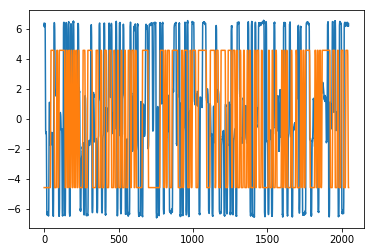

In [2]:
from Transmitter import Tx
from Receiver import Rx
from Fiber import Fiber,Amplifier

tx = Tx()
rx = Rx()
fiber = Fiber(tx.lam_set,length=1e5,alphaB=0.2,n2=2.7e-20,disp=17,dz=100,Nch=config.Nch)
comp = Fiber(tx.lam_set[0:2],length=1e5,alphaB=-0.2,n2=-1*2.7e-20,disp=-17,dz=100,Nch=2)
gerbio = fiber.alphaB*fiber.length/1e3 + comp.alphaB*comp.length/1e3
amp = Amplifier(gerbio)

# fiber channel
Ein,symbol_stream,bit_stream = tx.wdm_signal_sample()
Ercv = fiber(Ein)

# DBP
Ecomp = comp(Ercv[0:2])
Eout = amp(Ecomp)

# show signal figrue
plt.plot((Eout[0].imag))
plt.plot((Ein[0].imag))

In [4]:
predict = rx.receiver(Eout[0],Nch=0)
num = torch.sum(predict == bit_stream[0]).item()
acc = num / len(predict)
print('The acc is %d %%' % (acc*100))

TypeError: object of type 'int' has no len()

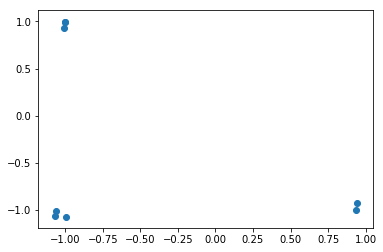

In [5]:
I = rx.filter(Eout[0],Nch=0)
rx.show_symbol(I)

In [8]:
help(plt.scatter)

Help on function scatter in module matplotlib.pyplot:

scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, hold=None, data=None, **kwargs)
    Make a scatter plot of `x` vs `y`
    
    Marker size is scaled by `s` and marker color is mapped to `c`
    
    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data
    
    s : scalar or array_like, shape (n, ), optional
        size in points^2.  Default is `rcParams['lines.markersize'] ** 2`.
    
    c : color, sequence, or sequence of color, optional, default: 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs
        (see below). Note that `c` should not be a single numeric RGB or
        RGBA sequence because that is indistinguishable from an array 

In [5]:
class SSFM(object):
    def __init__(self,T,N,h,alpha,beta1,beta2,gamma):
        self.T = T   # 时间信号 [0,T]
        self.N = N   # 信号采样长度 N
        self.h = h   # 演化步长
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.gamma = gamma
        self.W = fftshift(np.arange(self.N) - 0.5*self.N)
        self.H = np.exp(0.5*h*(-0.5*self.alpha + (1j)*(self.beta1 * self.W + 0.5*self.beta2 * self.W**2 )))
    

    def D(self,x):
        return ifft(self.H * fft(x))

    def P(self,x):
        return abs(x)**2
    
    def E(self,x):
        return np.exp(1j * self.gamma * self.h * x)

    def evolve(self,A,t):
        for i in range(int(t/self.h)):
            Da = self.D(A)
            Pa = self.P(A)
            A1 = self.D(Da * self.E(Pa))
            P = 0.5*(self.P(A1) + Pa)
            A = self.D(Da * self.E(P))
        
        return A

def generate_pulse(n):
    x = np.linspace(-10,10,n)
    return np.exp(-0.5* (x)**2)*np.cos(10*x)+np.exp(-0.5* (x)**2)*np.cos(5*x)  #*np.cos(10*x)

pulse = generate_pulse(1000)
plt.plot(pulse)

In [10]:
alpha = 0
gamma = 0.1
beta1 = 1
beta2 = 0.000
ssfm = SSFM(T=1,N=1000,h=0.01,alpha=alpha,beta1=beta1,beta2=beta2,gamma=gamma)
ssfm1 = SSFM(T=1,N=1000,h=0.01,alpha=-alpha,beta1=-beta1,beta2=-beta2,gamma=-gamma)

plt.plot(np.linspace(0,1,1000),pulse)
y10 = ssfm.evolve(pulse,100)
plt.plot(np.linspace(0,1,1000),np.abs(y10))

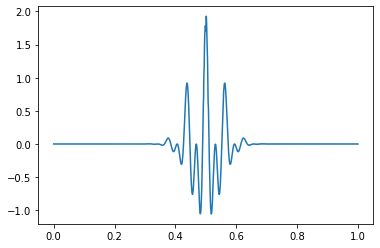

In [1353]:
y0 = ssfm1.evolve(y10,100)
plt.plot(np.linspace(0,1,1000),y0.real)